# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#uBoost-example" data-toc-modified-id="uBoost-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>uBoost example</a></div><div class="lev2 toc-item"><a href="#Load-the-data" data-toc-modified-id="Load-the-data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load the data</a></div><div class="lev2 toc-item"><a href="#Initial-view-of-the-data" data-toc-modified-id="Initial-view-of-the-data-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Initial view of the data</a></div><div class="lev2 toc-item"><a href="#Prepare-the-data-for-machine-learning" data-toc-modified-id="Prepare-the-data-for-machine-learning-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Prepare the data for machine learning</a></div><div class="lev1 toc-item"><a href="#Learning-to-pivot-example" data-toc-modified-id="Learning-to-pivot-example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning to pivot example</a></div><div class="lev2 toc-item"><a href="#Prepare-data" data-toc-modified-id="Prepare-data-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare data</a></div><div class="lev2 toc-item"><a href="#Set-network-architecture" data-toc-modified-id="Set-network-architecture-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Set network architecture</a></div><div class="lev2 toc-item"><a href="#Pretraing-without-adversary" data-toc-modified-id="Pretraing-without-adversary-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Pretraing without adversary</a></div><div class="lev2 toc-item"><a href="#Adverserial-training-of-f-and-r" data-toc-modified-id="Adverserial-training-of-f-and-r-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Adverserial training of f and r</a></div>

# Introduction

Recently, there have been works to show how machine learning algorithms can sculpt the shape of certain variables, which can make the systematics worse. Therefore, attempts have been made to come up with techniques to mitigate this and reduce the sculpting. In particular, this notebook will take a look at the relative performace of uBoost versus Adverserial techniques.

 * [uBoost](https://arxiv.org/abs/1305.7248) treats uniformity as part of the goal of the boosting of a decision tree. Code can be found [here](https://arogozhnikov.github.io/hep_ml/uboost.html).
 
 * [Learning to pivot](https://arxiv.org/abs/1611.01046) uses an adverserial network to infer the value(s) of interest from the output of the classifier. It has also been studdied in [this paper](1703.03507)
 
This notebook is going to go through the toy models presented in each of the two papers. Once we are able to reproduce their results, we will then apply the techniques to the opposite toy models and compare their performance. 

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize, root
from scipy.interpolate import interp1d
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib import gridspec as gs

plt.rcParams.update({'font.family': 'serif',
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'font.size': 12,
                     'mathtext.rm' : 'serif'
                    })
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.labelsize']=15

import ROOT as rt

# uBoost example

## Load the data

The data for uBoost is in a root file. There are probably better ways to load the data, but for now, use pyRoot to build a dataframe.

In [2]:
f = rt.TFile('./dalitzdata.root')
t = f.Get('tree')
total_length = t.GetEntries()

In [3]:
data = [['M2AB', 'M2AC', 'Y1', 'Y2', 'Y3']]
labels = []
for event in t:
    tmp_data = [event.M2AB, event.M2AC, event.Y1, event.Y2, event.Y3]
    data.append(tmp_data)
    labels.append(event.labels)
    
data = pd.DataFrame(data[1:], columns=data[0])
labels = np.array(labels)

## Initial view of the data

Make an initial plot of the datasets. The features that we would like to be flat are the $m^2_{AB}$ and $m^2_{AC}$, (i.e. columns 0 and 1).

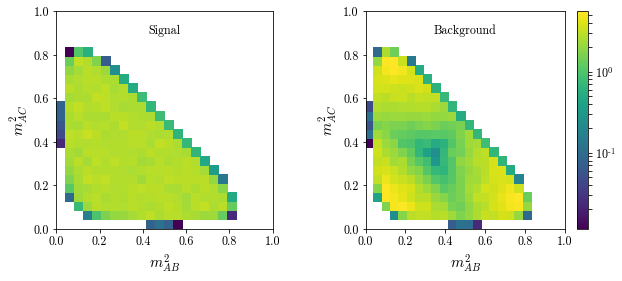

In [4]:
sighist, sigx, sigy = np.histogram2d(data[labels==1]['M2AB'], 
                                     data[labels==1]['M2AC'], 
                                     normed=True, 
                                     bins=[np.linspace(0,1,25), np.linspace(0,1,25)]
                                    )
sighist = sighist.T

backhist, backx, backy = np.histogram2d(data[labels==0]['M2AB'], 
                                        data[labels==0]['M2AC'], 
                                        normed=True,
                                        bins=[np.linspace(0,1,25), np.linspace(0,1,25)]
                                       )
backhist = backhist.T

setvmax = max(np.max(sighist), np.max(backhist))
setvmin = min(np.min(sighist[sighist > 0]), np.min(backhist[backhist > 0]))

X, Y = np.meshgrid(sigx, sigy)

#********************
# Frame
#********************

plt.figure(figsize=(10, 4))
gs1 = gs.GridSpec(1,2, width_ratios=[4,4.6], wspace=0.4)

#********************
# Signal
#********************
ax1 = plt.subplot(gs1[0])
plt.pcolor(X, Y, sighist,
#            vmin=setvmin, vmax=setvmax
           norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, 'Signal', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# Background
#********************
plt.subplot(gs1[1])
c1 = plt.pcolor(X,Y, backhist,
#                 vmin=setvmin, vmax=setvmax
                norm=LogNorm(vmin=setvmin, vmax=setvmax)
               )
plt.text(0.5,0.9, 'Background', ha='center')
cbar1=plt.colorbar(c1)
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

plt.show()

As we can see, the background has many more events at the corner of the Dalitz plot. The goal will be to make classifier which can cut out background without sculpting the Dalitz plot.

## Prepare the data for machine learning

In [5]:
trainX, testX, trainY, testY = train_test_split(data, labels, random_state=42)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from hep_ml.commonutils import train_test_split
from hep_ml import uboost, gradientboosting as ugb, losses

In [7]:
n_estimators = 150
uniform_f=['M2AB', 'M2AC']
train_f=['Y1', 'Y2', 'Y3']


base_estimator = DecisionTreeClassifier(max_depth=4)
base_estimator.fit(trainX[train_f], trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
uboost_dalitz = uboost.uBoostClassifier(uniform_features=uniform_f,
                                        uniform_label=0,
                                        base_estimator=base_estimator,
                                        n_estimators=n_estimators,
                                        train_features=train_f,
                                        efficiency_steps=10,
                                        n_threads=4                                        
                                       )

In [9]:
uboost_dalitz.fit(trainX,
                  trainY
                 )

uBoostClassifier(algorithm='SAMME',
         base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         efficiency_steps=10, n_estimators=150, n_neighbors=None,
         n_threads=4, random_state=None, smoothing=1.0, subsample=1.0,
         train_features=['Y1', 'Y2', 'Y3'],
         uniform_features=['M2AB', 'M2AC'], uniform_label=0)

We want to compare this with a base BDT classifier. Use AdaBoost from scikit-learn.

In [10]:
base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
base_ada.fit(testX[train_f], testY)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Make the predictions and plot the results

In [11]:
uboost_preds = uboost_dalitz.predict_proba(testX)
ada_preds = base_ada.predict_proba(testX[train_f])

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(testY,
                                         uboost_preds[:,1])

fpr_ada, tpr_ada, thresholds_ada = metrics.roc_curve(testY,
                                                     ada_preds[:,1])

uboost_dalitz_score = metrics.auc(fpr, tpr)
ada_dalitz_score = metrics.auc(fpr_ada, tpr_ada)

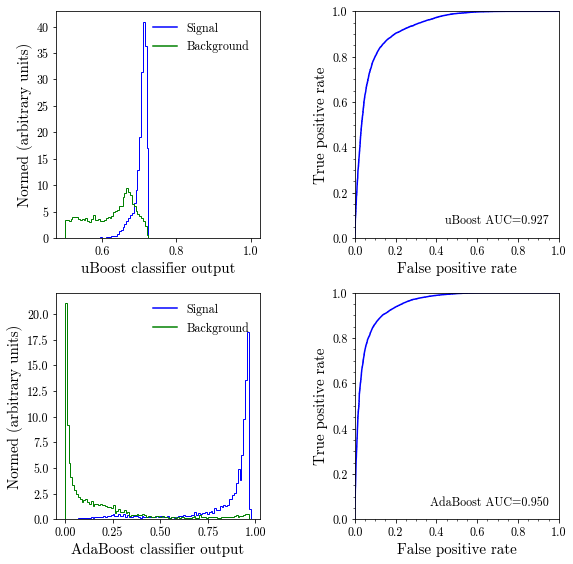

In [13]:
plt.figure(figsize=(8,8))

#********************
# BDT Output
#********************
plt.subplot(2,2,1)
plt.hist(uboost_preds[testY==1][:,1], 
#          range=(0.5,1),
         bins=100,
         histtype='step',
         color='b',
         density=True
        )
plt.hist(uboost_preds[testY==0][:,1], 
#          range=(0.5,1),
         bins=100,
         histtype='step',
         color='g',
         density=True
        )
plt.plot([],[],c='b',label='Signal')
plt.plot([],[],c='g',label='Background')

plt.legend(loc='best', frameon=False)
plt.xlabel('uBoost classifier output')
plt.ylabel('Normed (arbitrary units)')

#********************
# ROC Curve
#********************
plt.subplot(2,2,2)
plt.plot(fpr, tpr, c='b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.minorticks_on()
plt.text(0.95, 0.05, 'uBoost AUC={0:0.3f}'.format(uboost_dalitz_score), ha='right', va='bottom')

#********************
# BDT Output
#********************
plt.subplot(2,2,3)
plt.hist(ada_preds[testY==1][:,1], 
#          range=(0.5,1),
         bins=100,
         histtype='step',
         color='b',
         density=True
        )
plt.hist(ada_preds[testY==0][:,1], 
#          range=(0.5,1),
         bins=100,
         histtype='step',
         color='g',
         density=True
        )
plt.plot([],[],c='b',label='Signal')
plt.plot([],[],c='g',label='Background')

plt.legend(loc='best', frameon=False)
plt.xlabel('AdaBoost classifier output')
plt.ylabel('Normed (arbitrary units)')

#********************
# ROC Curve
#********************
plt.subplot(2,2,4)
plt.plot(fpr_ada, tpr_ada, c='b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.minorticks_on()
plt.text(0.95, 0.05, 'AdaBoost AUC={0:0.3f}'.format(ada_dalitz_score), ha='right', va='bottom')

plt.tight_layout(w_pad=4)

Choose a working point that gives a signal efficiency, $\epsilon_s = 0.7$. Then plot the dalitz plots of the signal and background that pass the selection.

In [14]:
cut_value = thresholds[np.argmin(np.abs(tpr - 0.7))]
eps_s = float(sum(uboost_preds[testY==1][:,1] > cut_value)) / len(uboost_preds[testY==1])
eps_b = float(sum(uboost_preds[testY==0][:,1] > cut_value)) / len(uboost_preds[testY==0])
print r'Cut value is {0:0.3f} with epsilon_s={1:0.3f} and epsilon_b={2:0.3f}'.format(cut_value, eps_s, eps_b) 

Cut value is 0.701 with epsilon_s=0.700 and epsilon_b=0.065


In [15]:
cut_value_ada = thresholds_ada[np.argmin(np.abs(tpr_ada - 0.7))]
eps_s_a = float(sum(ada_preds[testY==1][:,1] > cut_value_ada)) / len(ada_preds[testY==1])
eps_b_a = float(sum(ada_preds[testY==0][:,1] > cut_value_ada)) / len(ada_preds[testY==0])
print r'Cut value is {0:0.3f} with epsilon_s={1:0.3f} and epsilon_b={2:0.3f}'.format(cut_value_ada, 
                                                                                     eps_s_a, eps_b_a) 

Cut value is 0.836 with epsilon_s=0.700 and epsilon_b=0.041


In [16]:
cut_testX = testX[uboost_preds[:,1] > cut_value]
cut_testY = testY[uboost_preds[:,1] > cut_value]

cut_testX_a = testX[ada_preds[:,1] > cut_value_ada]
cut_testY_a = testY[ada_preds[:,1] > cut_value_ada]

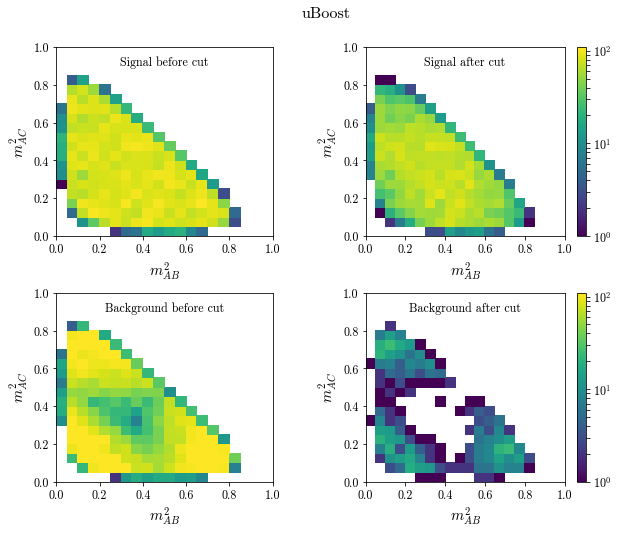

In [17]:
beforehist, sigx, sigy = np.histogram2d(testX[testY==1]['M2AB'],
                                        testX[testY==1]['M2AC'],
#                                         normed=True,
                                        bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
                                    )
beforehist = beforehist.T

afterhist, sigx, sigy = np.histogram2d(cut_testX[cut_testY==1]['M2AB'],
                                       cut_testX[cut_testY==1]['M2AC'],
#                                        normed=True,
                                       bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
                                    )
afterhist = afterhist.T

beforehistback, sigx, sigy = np.histogram2d(testX[testY==0]['M2AB'],
                                            testX[testY==0]['M2AC'],
#                                         normed=True,
                                            bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
                                    )
beforehist = beforehist.T

afterhistback, sigx, sigy = np.histogram2d(cut_testX[cut_testY==0]['M2AB'],
                                           cut_testX[cut_testY==0]['M2AC'],
#                                        normed=True,
                                           bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
                                    )
afterhist = afterhist.T

setvmax = max(np.max(beforehist), np.max(afterhist))
setvmin = min(np.min(beforehist[beforehist > 0]), np.min(afterhist[afterhist > 0]))
X, Y = np.meshgrid(sigx, sigy)

#********************
# Frame
#********************

plt.figure(figsize=(10, 8))
gs1 = gs.GridSpec(2,2, width_ratios=[4,4.6], wspace=0.4, hspace=0.3)

#********************
# Before
#********************
ax1 = plt.subplot(gs1[0])
plt.pcolor(X, Y, beforehist,
#            vmin=setvmin, vmax=setvmax
           norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, 'Signal before cut', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# After
#********************
plt.subplot(gs1[1])
c1 = plt.pcolor(X,Y, afterhist,
#                 vmin=setvmin, vmax=setvmax
                norm=LogNorm(vmin=setvmin, vmax=setvmax)
               )
plt.text(0.5,0.9, 'Signal after cut', ha='center')
cbar1=plt.colorbar(c1)
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# Before
#********************
ax1 = plt.subplot(gs1[2])
plt.pcolor(X, Y, beforehistback,
#            vmin=setvmin, vmax=setvmax
           norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, 'Background before cut', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# After
#********************
plt.subplot(gs1[3])
c1 = plt.pcolor(X,Y, afterhistback,
#                 vmin=setvmin, vmax=setvmax
                norm=LogNorm(vmin=setvmin, vmax=setvmax)
               )
plt.text(0.5,0.9, 'Background after cut', ha='center')
cbar1=plt.colorbar(c1)
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

plt.suptitle('uBoost', y=0.95, fontsize=16)
plt.show()

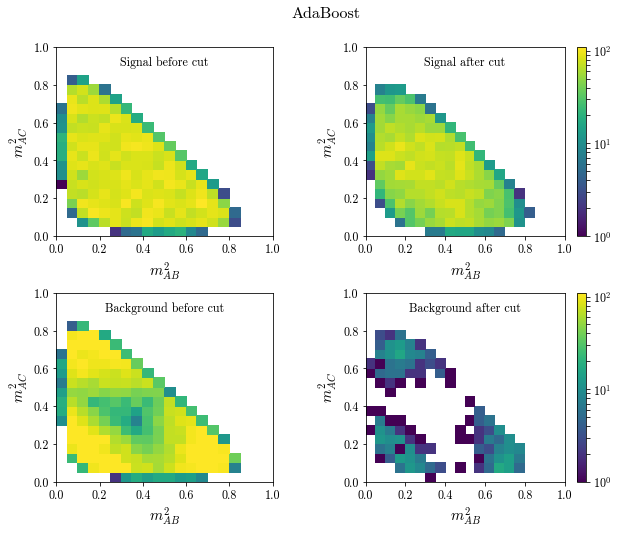

In [18]:
afterhist_a, sigx, sigy = np.histogram2d(cut_testX_a[cut_testY_a==1]['M2AB'],
                                         cut_testX_a[cut_testY_a==1]['M2AC'],
#                                        normed=True,
                                       bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
                                    )
afterhist_a = afterhist_a.T


afterhistback_a, sigx, sigy = np.histogram2d(cut_testX_a[cut_testY_a==0]['M2AB'],
                                             cut_testX_a[cut_testY_a==0]['M2AC'],
                                             #                                        normed=True,
                                           bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
                                    )
afterhistback_a = afterhistback_a.T

setvmax = max(np.max(beforehist), np.max(afterhist))
setvmin = min(np.min(beforehist[beforehist > 0]), np.min(afterhist[afterhist > 0]))
X, Y = np.meshgrid(sigx, sigy)

#********************
# Frame
#********************

plt.figure(figsize=(10, 8))
gs1 = gs.GridSpec(2,2, width_ratios=[4,4.6], wspace=0.4, hspace=0.3)

#********************
# Before
#********************
ax1 = plt.subplot(gs1[0])
plt.pcolor(X, Y, beforehist,
#            vmin=setvmin, vmax=setvmax
           norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, 'Signal before cut', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# After
#********************
plt.subplot(gs1[1])
c1 = plt.pcolor(X,Y, afterhist_a,
#                 vmin=setvmin, vmax=setvmax
                norm=LogNorm(vmin=setvmin, vmax=setvmax)
               )
plt.text(0.5,0.9, 'Signal after cut', ha='center')
cbar1=plt.colorbar(c1)
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# Before
#********************
ax1 = plt.subplot(gs1[2])
plt.pcolor(X, Y, beforehistback,
#            vmin=setvmin, vmax=setvmax
           norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, 'Background before cut', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

#********************
# After
#********************
plt.subplot(gs1[3])
c1 = plt.pcolor(X,Y, afterhistback_a,
#                 vmin=setvmin, vmax=setvmax
                norm=LogNorm(vmin=setvmin, vmax=setvmax)
               )
plt.text(0.5,0.9, 'Background after cut', ha='center')
cbar1=plt.colorbar(c1)
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')

plt.suptitle('AdaBoost', y=0.95, fontsize=16)
plt.show()

In [19]:
mycolors = [(.8, 0, 0), (1,1,1), (0, 0, 0.8)] 
nbins = 101
cmap_name = 'mycmap'
mycm = colors.LinearSegmentedColormap.from_list(cmap_name, mycolors, nbins)

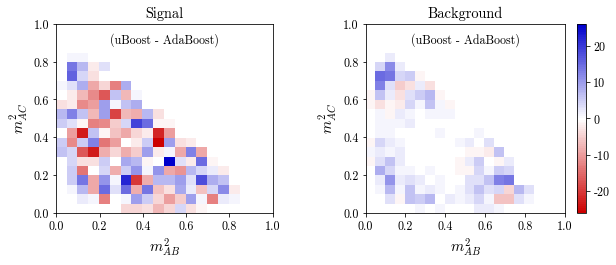

The total difference in uBoost - AdaBoost for epsilon_s=0.7 is -3.0
Background Diff: uBoost - AdaBoost for epsilon_s=0.7 is 296.0


In [20]:
setvmax = np.max(afterhist - afterhist_a)
setvmin = -setvmax
X, Y = np.meshgrid(sigx, sigy)

#********************
# Frame
#********************
plt.figure(figsize=(10, 8))
gs1 = gs.GridSpec(2,2, width_ratios=[4,4.6], wspace=0.4, hspace=0.3)

#********************
# Before
#********************
ax1 = plt.subplot(gs1[0])
plt.pcolor(X, Y, afterhist - afterhist_a,
           vmin=setvmin, vmax=setvmax, cmap=mycm,
#            norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, '(uBoost - AdaBoost)', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')
plt.title('Signal')

#********************
# Before
#********************
ax1 = plt.subplot(gs1[1])
c1 = plt.pcolor(X, Y, afterhistback - afterhistback_a,
           vmin=setvmin, vmax=setvmax, cmap=mycm,
#            norm=LogNorm(vmin=setvmin, vmax=setvmax)
          )
plt.text(0.5,0.9, '(uBoost - AdaBoost)', ha='center')
plt.xlabel(r'$m^2_{AB}$')
plt.ylabel(r'$m^2_{AC}$')
cbar1=plt.colorbar(c1)
plt.title('Background')

plt.show()

diff = np.sum(afterhist) - np.sum(afterhist_a)
diff_b = np.sum(afterhistback) - np.sum(afterhistback_a)
print 'The total difference in uBoost - AdaBoost for epsilon_s=0.7 is {}'.format(diff)
print 'Background Diff: uBoost - AdaBoost for epsilon_s=0.7 is {}'.format(diff_b)

By comparing the signal regions in the uBoost - AdaBoost samples, we see that uBoost keeps more events in the corners, while AdaBoost keeps more events in the central regions. This happens because AdaBoost removes more events in the corners (where the background is larger).

Now that we have seen a little about how uBoost works, let us go through the 'Learning to Pivot' toy model.

# Learning to pivot example

The toy model for this paper looks at separating to normal distributions, when there is a systematic that should be flattened.

## Prepare data

In [21]:
nsamples = 125000
X0 = np.random.multivariate_normal([0, 0],  # means
                                   [[1.0, -0.5],
                                    [-0.5, 1.0]
                                   ],  # covariance
                                   nsamples / 2
                                  )
X1 = np.random.multivariate_normal([1., 1.],  # means
                                   [[1.0, 0],[0,1.0]],  # covariance
                                   nsamples / 2
                                  )
z = np.random.normal(0, 1, nsamples) 
X1[:, 1] += z[nsamples / 2 :]

X = np.vstack([X0, X1])
y = np.zeros(nsamples)
y[nsamples / 2 :] = 1
print len(X), len(y), len(z)

125000 125000 125000


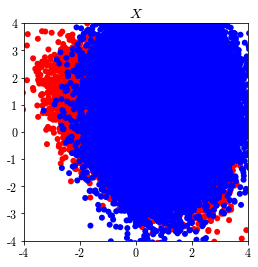

In [22]:
plt.figure(figsize=(4,4))
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [23]:
Xp_train, Xp_valid, yp_train, yp_valid, zp_train, zp_valid = train_test_split(X, y, z, test_size=50000)

## Set network architecture

In [24]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(inputs=[inputs], outputs=[Dx])

n_components = 5
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="linear")(Rx)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Merge(mode="concat")([mu, sigma, pi])

R = Model(inputs=[inputs], outputs=[Rx])

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/bryan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/Users/bryan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/bryan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [25]:
from keras.optimizers import adam, SGD
import keras.backend as K

lam = 50.0 

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_true, y_pred)
    return loss_D

def make_loss_R(lam, n_components):
    def loss(y_true, y_pred):
        y_true = K.flatten(y_true)
        
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
        nll = -K.log(pdf)
        
        return lam * K.mean(nll)
    
    return loss

opt_D = adam()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD()
DRf = Model(inputs=[inputs], outputs=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(-lam, n_components)],   
            optimizer=opt_DRf)

opt_DfR = SGD()
DfR = Model(inputs=[inputs], outputs=[R(inputs)])
DfR.compile(loss=[make_loss_R(1.0, n_components)], 
            optimizer=opt_DfR)

/Users/bryan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/Users/bryan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [26]:
DRf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            501         input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 15)           1276        input_1[0][0]                    
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
__________________________________________________________________________________________________


In [27]:
DfR.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
model_2 (Model)              (None, 15)                1276      
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
_________________________________________________________________


## Pretraing without adversary

In [28]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(Xp_train, yp_train, epochs=20, batch_size=1000)
min_Lf = D.evaluate(Xp_valid, yp_valid)

Epoch 1/20
75000/75000 [==============================] - 1s 18us/step - loss: 0.5991
Epoch 2/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4819
Epoch 3/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4623
Epoch 4/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4574
Epoch 5/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4558
Epoch 6/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4551
Epoch 7/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4547
Epoch 8/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4545
Epoch 9/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4542
Epoch 10/20
75000/75000 [==============================] - 0s 4us/step - loss: 0.4538
Epoch 11/20
75000/75000 [==============================] - 0s 3us/step - loss: 0.4534
Epoch 12/20
75000/75000 [==============================] - 0s 

In [29]:
def make_X(n_samples, z):
    x0 = np.random.multivariate_normal([0, 0],  # means
                                       [[1.0, -0.5],
                                        [-0.5, 1.0]
                                       ],  # covariance
                                       n_samples / 2
                                  )
    x1 = np.random.multivariate_normal([1., 1.],  # means
                                       [[1.0, 0],[0,1.0]],  # covariance
                                       n_samples / 2
                                  )
    x1[:, 1] += z
    xout = np.vstack([x0, x1])
    yout = np.zeros(n_samples)
    yout[n_samples // 2:] = 1
    return xout

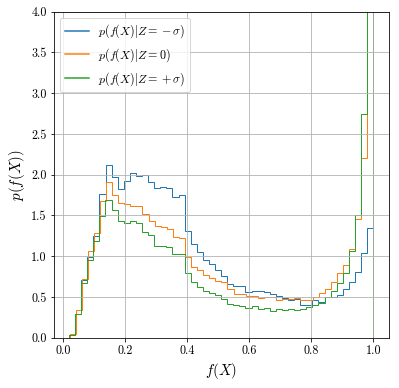

In [30]:
plt.figure(figsize=(6,6))
plt.hist(D.predict(make_X(200000, z=-1)), bins=50, color='C0', density=1, histtype="step")
plt.hist(D.predict(make_X(200000, z=0)), bins=50, color='C1', density=1, histtype="step")
plt.hist(D.predict(make_X(200000, z=1)), bins=50, color='C2', density=1, histtype="step")

plt.plot([],[], color='C0', label="$p(f(X)|Z=-\sigma)$")
plt.plot([],[], color='C1', label="$p(f(X)|Z=0)$")
plt.plot([],[], color='C2', label="$p(f(X)|Z=+\sigma)$")
plt.legend(loc="best")

plt.ylim(0,4)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.grid()
plt.legend(loc="upper left",)
plt.show()

## Adverserial training of f and r

In [31]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.compile(loss=[make_loss_R(1.0, n_components)], 
            optimizer=opt_DfR)
DfR.fit(Xp_train, zp_train, epochs=20) #, batch_size=1000)

Epoch 1/20
75000/75000 [==============================] - 16s 220us/step - loss: 1.4060
Epoch 2/20
75000/75000 [==============================] - 16s 208us/step - loss: 1.3881
Epoch 3/20
75000/75000 [==============================] - 16s 210us/step - loss: 1.3794
Epoch 4/20
75000/75000 [==============================] - 15s 201us/step - loss: 1.3760
Epoch 5/20
75000/75000 [==============================] - 15s 203us/step - loss: 1.3741
Epoch 6/20
75000/75000 [==============================] - 15s 198us/step - loss: 1.3729
Epoch 7/20
75000/75000 [==============================] - 16s 207us/step - loss: 1.3717
Epoch 8/20
75000/75000 [==============================] - 15s 201us/step - loss: 1.3706
Epoch 9/20
75000/75000 [==============================] - 15s 204us/step - loss: 1.3696
Epoch 10/20
75000/75000 [==============================] - 15s 206us/step - loss: 1.3690
Epoch 11/20
75000/75000 [==============================] - 15s 199us/step - loss: 1.3682
Epoch 12/20
75000/75000 [=====

In [32]:
from IPython import display

min_Lr = np.log(1 * (2. * np.pi * np.e) ** 0.5)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.tight_layout() 
    plt.show()

In [33]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

<Figure size 432x288 with 0 Axes>

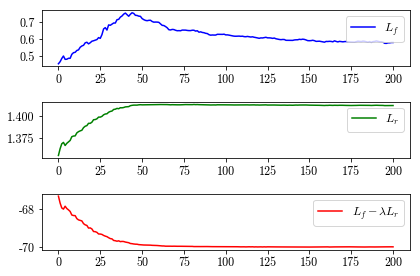

Epoch 1/1
75000/75000 [==============================] - 54s 715us/step - loss: 1.4186


In [34]:
batch_size = 128

for i in range(201):
    l = DRf.evaluate(Xp_valid, [yp_valid, zp_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_r"][-1] / lam)
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(Xp_train))[:batch_size]
    DRf.compile(loss=[make_loss_D(c=1.0),
                      make_loss_R(-lam, n_components)],
                optimizer=opt_DRf)
    DRf.train_on_batch(Xp_train[indices], [yp_train[indices], zp_train[indices]])
        
    # Fit R
    D.trainable = False
    R.trainable = True
    DfR.compile(loss=[make_loss_R(1.0, n_components)],
                optimizer=opt_DfR)
    DfR.fit(Xp_train, zp_train, batch_size=batch_size, epochs=1, verbose=1)

#     for j in range(200):
#         indices = np.random.permutation(len(X_train))
#         DfR.train_on_batch(X_train[indices], z_train[indices])

/Users/bryan/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


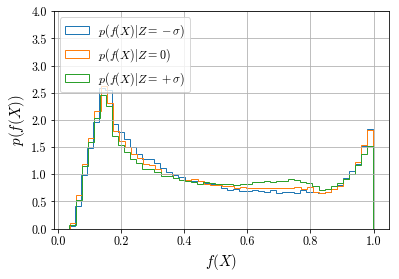

In [35]:
plt.hist(D.predict(make_X(200000, z=-1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=-\sigma)$")
plt.hist(D.predict(make_X(200000, z=0)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(D.predict(make_X(200000, z=1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=+\sigma)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("f-adversary.pdf")
plt.show()